# Notes

1) Trained model with **lr = 1e-4 with dropout for 600 epochs** - val accuracy around 69-70 and test accuracy for unskipped images is 77
2) Adding more conv layers didn't seem to help - needs to be investigated/experimented further
3) **Increasing model ensemble size beyond 1 during prediction results in resource exhaustion on my local GPU - need GPU with high memory**

In [ ]:
!pip install --upgrade tensorflow-gpu==2.5.0

In [ ]:
!pip install --upgrade tensorflow-probability==0.13.0

# Bayesian Models for SDSS data

## Libraries

In [1]:
import astroNN
import os
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import tensorflow_probability as tfp 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numba import cuda 
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import json

tfd = tfp.distributions
tfpl = tfp.layers
device = cuda.get_current_device()

plt.rcParams['figure.figsize'] = (10, 6)

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


## Tf and Tfp versions

Ensure that versions are 2.5.0 and 0.13.0

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Load data

In [3]:
images, labels = load_galaxy10()
labels = labels.astype(np.float32)
#labels = to_categorical(labels)
images = images.astype(np.float32)
images = images/255 

C:\SPB_DATA\.astroNN\datasets\Galaxy10.h5 was found!


## Visualise input-output pairs

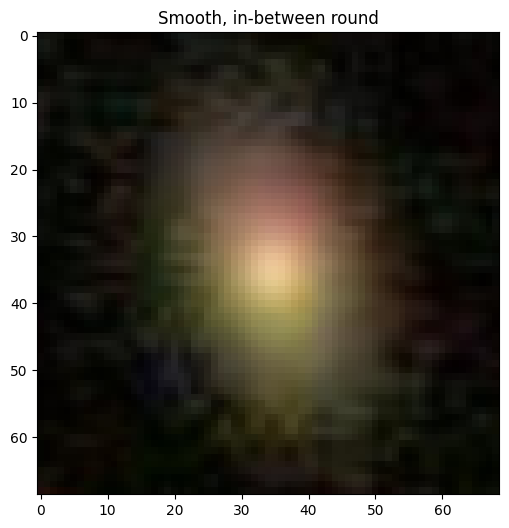

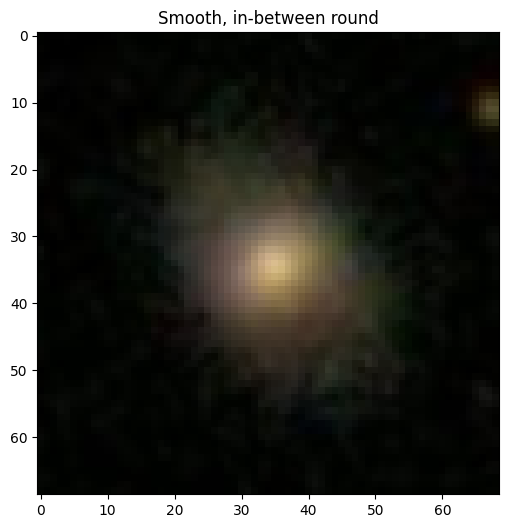

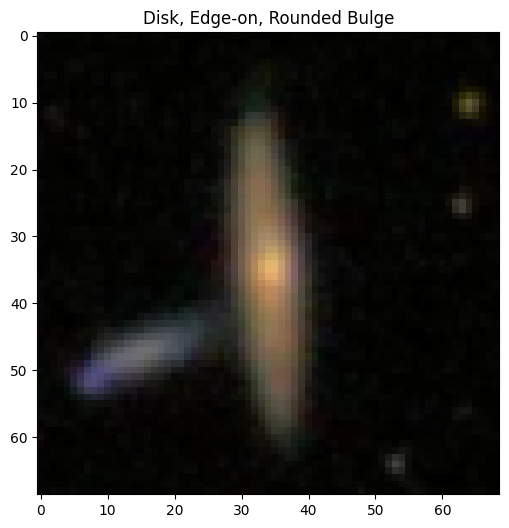

In [4]:
def show_image(image_data,label):
    label = galaxy10cls_lookup(int(label))
    plt.imshow(image_data)
    plt.title(label)
    plt.show()
for i in range(3):
    show_image(images[i], labels[i])

## Train-Val-Test split

In [5]:
images_dict = {0: [], 1: [],2: [],3: [],4: [],5: [],6: [],7: [],8: [],9: []}
labels_dict = {0: [], 1: [],2: [],3: [],4: [],5: [],6: [],7: [],8: [],9: []}
include_classes = [1,2,4]
X_train = []
X_val = []
X_test = []
y_train = []
y_val = []
y_test = []

In [6]:
for image, label in zip(images, labels):
    true_label = label
    images_dict[true_label].append(image)
    labels_dict[true_label].append(label)
    
for i in range(10):
    images_dict[i] = np.array(images_dict[i])
    labels_dict[i] = np.array(labels_dict[i])

In [7]:
for i in range(10):
    if i in include_classes:
        x_train, x_val_test, Y_train, Y_val_test = train_test_split(images_dict[i], labels_dict[i], test_size = 0.20, random_state = 10)
        x_val, x_test, Y_val, Y_test = train_test_split(x_val_test, Y_val_test, test_size = 0.50, random_state = 10)
        for ele in x_train:
            X_train.append(ele)
        for ele in Y_train:
            y_train.append(ele)
        for ele in x_val:
            X_val.append(ele)
        for ele in Y_val:
            y_val.append(ele)
        for ele in x_test:
            X_test.append(ele)
        for ele in Y_test:
            y_test.append(ele)
    else:
        #x_val, x_test, Y_val, Y_test = train_test_split(images_dict[i], labels_dict[i], test_size = 0.50, random_state = 10)
        #for ele in x_val:
           # X_val.append(ele)
        #for ele in Y_val:
          #  y_val.append(ele)
        for ele in list(images_dict[i]):
            X_test.append(ele)
        for ele in list(labels_dict[i]):
            y_test.append(ele)



In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)


In [9]:
y_train[0]

1.0

In [10]:
y_val[0]

1.0

In [11]:
def custom_to_categorical(labels = None):
    new_labels = []
    #one_hot = {1: [1,0,0,0],2: [0,1,0,0], 4:[0,0,1,0], 6:[0,0,0,1]}
    one_hot = {1: [1,0,0],2: [0,1,0], 4:[0,0,1]}
    for label in labels:
        new_labels.append(one_hot[int(label)])
    new_labels = np.array(new_labels).astype(np.float32)
    return new_labels

In [12]:
y_train = custom_to_categorical(labels = y_train)
y_val = custom_to_categorical(labels = y_val)

In [13]:
y_train[0]

array([1., 0., 0.], dtype=float32)

In [14]:
y_val[0]

array([1., 0., 0.], dtype=float32)

In [15]:
idx = np.random.permutation(len(X_train))
X_train,y_train = X_train[idx], y_train[idx]

In [16]:
print(images.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(21785, 69, 69, 3)
(11857, 69, 69, 3)
(11857, 3)
(8446, 69, 69, 3)
(8446,)
(1482, 69, 69, 3)
(1482, 3)


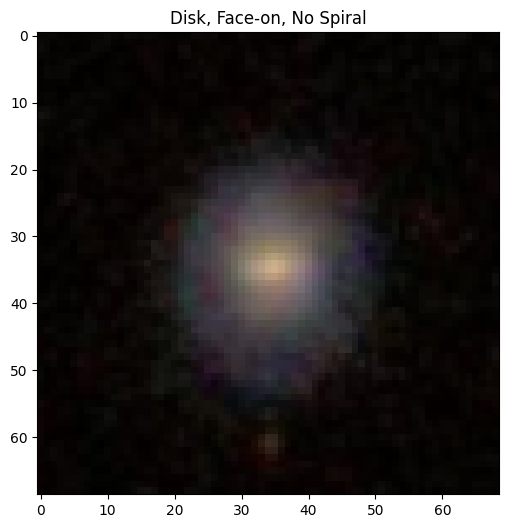

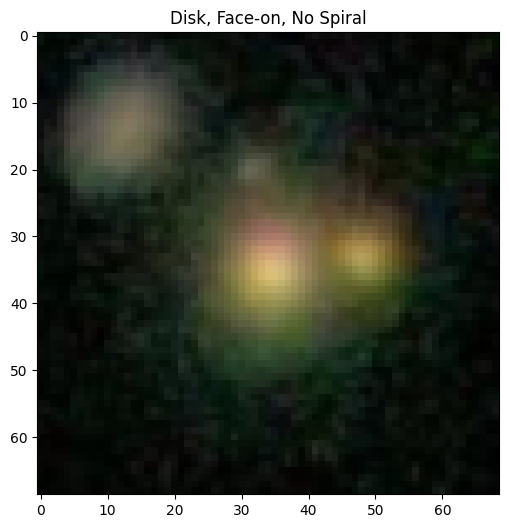

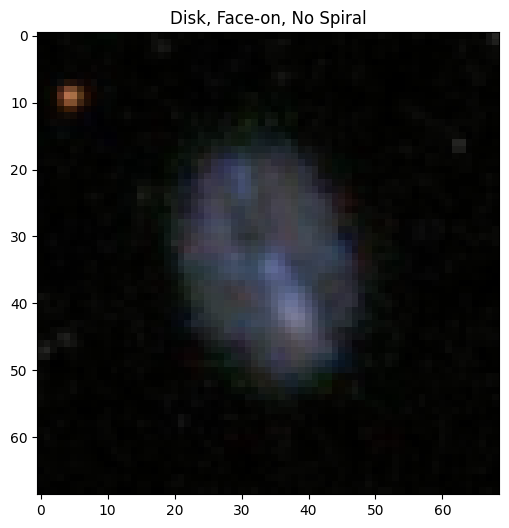

In [17]:
for i in range(3):
    show_image(X_test[i], y_test[i])

## Utility functions

### Negative log likelihood

In [18]:
def nll(y_true, y_pred):
    """
    This function should return the negative log-likelihood of each sample
    in y_true given the predicted distribution y_pred. If y_true is of shape 
    [B, E] and y_pred has batch shape [B] and event_shape [E], the output 
    should be a Tensor of shape [B].
    """
    return -y_pred.log_prob(y_true)

## Flipout convolution

In [19]:
def get_convolutional_flipout_layer(input_shape, divergence_fn , f ,k, padding, activation):
    
    layer = tfpl.Convolution2DFlipout(
                input_shape=input_shape, filters=f, kernel_size=(k, k),
                activation=activation, padding=padding,
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
                )
    
    return layer

### Flipout dense layer

In [20]:
def get_dense_flipout_layer(divergence_fn, units):
    
    layer = tfpl.DenseFlipout(
                 units = units, activation = None,
                 kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                 bias_prior_fn = tfpl.default_multivariate_normal_fn,
                 bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_divergence_fn = divergence_fn,
                 bias_divergence_fn = divergence_fn)
    
    return layer

## Set seed and define divergence functions

In [21]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

## Model 3

Same architecture as Sarvesh's but with Flipout layers this time

### Build model

In [22]:
bayesian_model_flip = Sequential([
    get_convolutional_flipout_layer(
    input_shape=(69, 69, 3), divergence_fn=divergence_fn, f = 32, k =3, padding = 'VALID', activation = 'relu'),
    get_convolutional_flipout_layer(
    input_shape=(67, 67, 32), divergence_fn=divergence_fn, f = 64, k =3, padding = 'VALID', activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_flipout_layer(
    input_shape=(32, 32, 64), divergence_fn=divergence_fn, f = 64, k =3, padding = 'VALID', activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_flipout_layer(
    input_shape=(15, 15, 64), divergence_fn=divergence_fn, f = 64, k =3, padding = 'VALID', activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    get_convolutional_flipout_layer(
    input_shape=(6, 6, 64), divergence_fn=divergence_fn, f = 64, k =3, padding = 'VALID', activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    get_dense_flipout_layer(divergence_fn = divergence_fn, units = 64),
    Dropout(0.2),
    get_dense_flipout_layer(divergence_fn = divergence_fn, units = 32),
    Dropout(0.2),
    get_dense_flipout_layer(divergence_fn = divergence_fn, units = 16),
    Dropout(0.2),
    get_dense_flipout_layer(divergence_fn = divergence_fn, units = tfpl.OneHotCategorical.params_size(3)),
    tfpl.OneHotCategorical(3, convert_to_tensor_fn=tfd.Distribution.mode)
])

C:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [23]:
print(bayesian_model_flip.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 67, 67, 32)        1792      
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 65, 65, 64)        36992     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 30, 30, 64)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 13, 13, 64)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

**Compile and fit with learning rate set to 1e-3**

In [24]:
bayesian_model_flip.compile(loss=nll,
              optimizer=Adam(learning_rate = 1e-3),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [25]:
history_flip_bayes = bayesian_model_flip.fit(x=X_train, y=y_train, batch_size = 32, epochs = 100, validation_data = (X_val,y_val), verbose=True)

Epoch 1/100


KeyboardInterrupt: 

In [26]:
df_plot = pd.DataFrame.from_dict(history_flip_bayes.history)
df_plot.to_csv("./ckpt/run3/logs/epochs_100_classes_3.csv")
df_plot = pd.read_csv('./ckpt/run3/logs/epochs_100_classes_3.csv')

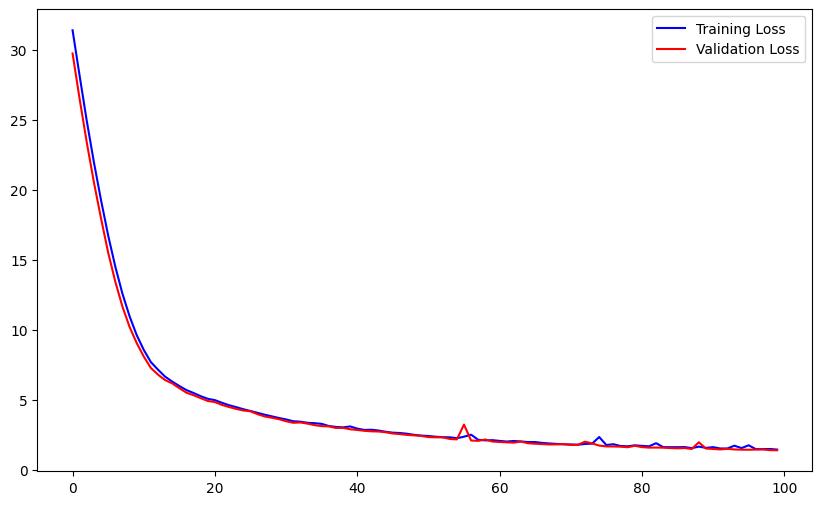

In [27]:
plt.plot(df_plot['loss'],color='b',
label='Training Loss')
plt.plot(df_plot['val_loss'],color='r',
label='Validation Loss')
plt.legend()
plt.show()

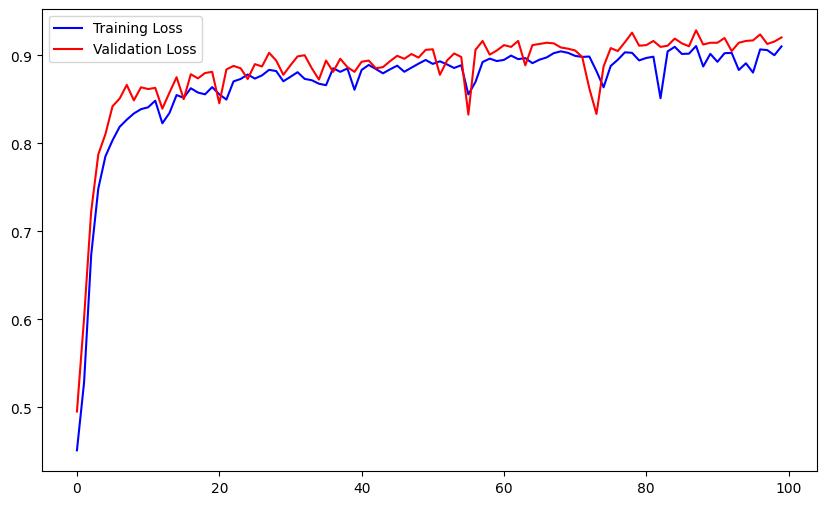

In [28]:
plt.plot(df_plot['accuracy'],color='b',
label='Training Loss')
plt.plot(df_plot['val_accuracy'],color='r',
label='Validation Loss')
plt.legend()
plt.show()

## Save weights of current best model and compute mean prob and std

To make predictions as per need, build the model as per need and then just load the weights using *model.load_weights(PATH)*

In [30]:
PATH = './ckpt/run3/model_weights/bayesian_CNN_flipout_layers_lr_1E-3_epochs_100_classes_3'
bayesian_model_flip.save_weights(PATH)

In [24]:
PATH = './ckpt/run3/model_weights/bayesian_CNN_flipout_layers_lr_1E-3_epochs_100_classes_3'
bayesian_model_flip.load_weights(PATH)

**Run the cell below only the first time - when resuming evaluation due to Resource Exhaustion Error, skip it and run the next cell**

In [37]:
df = {'label' : [],'class_1_list' : [],'class_2_list' : [], 'class_4_list' : []}
df =  pd.DataFrame(df)
df.to_csv("./ckpt/run3/prediction_probs.csv", index = False)

In [25]:
df = pd.read_csv('./ckpt/run3/prediction_probs.csv')

In [26]:
df.shape[0]

7937

In [27]:
def return_ensembled_prediction(image = None, ensemble_size = 2, model = None):
    predicted_probabilities = np.empty(shape=(ensemble_size, 3))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
        
    return predicted_probabilities

In [28]:
def calc_accuracy(images = X_test, labels = y_test, ensemble_size = None, model = None, threshold = None, df = None, initial = 0):
    
    for image, label in tqdm(zip(images,labels), total = 8446, initial = initial):
        classes_dict = {0: [], 1: [],2: []}
        pred_probs = return_ensembled_prediction(image = image, ensemble_size = ensemble_size, model = model)
        for col in range(pred_probs.shape[1]):
            single_class_probs = pred_probs[:,col]
            mean_class_prob = np.mean(single_class_probs)
            std_class_prob = np.std(single_class_probs)
            classes_dict[col].append(mean_class_prob)
            classes_dict[col].append(std_class_prob)
        
        df1 = {'label' : label,'class_1_list' : classes_dict[0],'class_2_list' : classes_dict[1], 'class_4_list' : classes_dict[2]}
        df = df.append(df1, ignore_index = True)
        
        df.to_csv("./ckpt/run3/prediction_probs.csv", index = False)

In [29]:
paused = df.shape[0]
calc_accuracy(images = X_test[paused:], labels = y_test[paused:], ensemble_size = 10, model = bayesian_model_flip, threshold = 0.95,
             df = df, initial = paused)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8446/8446 [14:43<00:00,  1.74s/it]


In [30]:
df = pd.read_csv('./ckpt/run3/prediction_probs.csv')

In [31]:
df.shape[0]

8446

In [32]:
results_df = {'class' : [],'class_1_list' : [],'class_2_list' : [], 'class_4_list' : []}
results_df =  pd.DataFrame(results_df)

for label in range(10):
    temp_df = df[df['label'] == label]
    
    class_1_list = list(temp_df['class_1_list'])
    class_1_list = [[float(ele[1:-1].split(',')[0]),float(ele[1:-1].split(',')[1])] for ele in class_1_list]
    class_1_list = np.array(class_1_list).astype(np.float32)
    u1 = np.mean(class_1_list[:,0])
    s1 = np.mean(class_1_list[:,1])
    c1 = [u1,s1]
    
    class_2_list = list(temp_df['class_2_list'])
    class_2_list = [[float(ele[1:-1].split(',')[0]),float(ele[1:-1].split(',')[1])] for ele in class_2_list]
    class_2_list = np.array(class_2_list).astype(np.float32)
    u2 = np.mean(class_2_list[:,0])
    s2 = np.mean(class_2_list[:,1])
    c2 = [u2,s2]
    
    class_4_list = list(temp_df['class_4_list'])
    class_4_list = [[float(ele[1:-1].split(',')[0]),float(ele[1:-1].split(',')[1])] for ele in class_4_list]
    class_4_list = np.array(class_4_list).astype(np.float32)
    u4 = np.mean(class_4_list[:,0])
    s4 = np.mean(class_4_list[:,1])
    c4 = [u4,s4]
    
    df1 = {'class' : label,'class_1_list' : c1,'class_2_list' : c2, 'class_4_list' : c4}
    results_df = results_df.append(df1, ignore_index = True)
    results_df.to_csv("./ckpt/run3/results.csv", index = False)
    
    
    
    
    
    
    

In [33]:
results_df

,class,class_1_list,class_2_list,class_4_list
0,0.0,"[0.37886307, 0.118325144]","[0.52315384, 0.16748422]","[0.09798309, 0.07303995]"
1,1.0,"[0.87899315, 0.08823709]","[0.11493927, 0.085037254]","[0.0060675377, 0.007928077]"
2,2.0,"[0.088471316, 0.08046595]","[0.87450147, 0.12093632]","[0.037027124, 0.05241015]"
3,3.0,"[0.005916849, 0.012971886]","[0.16035035, 0.15021306]","[0.8337328, 0.15534425]"
4,4.0,"[0.008936052, 0.012189524]","[0.060145315, 0.06300191]","[0.9309187, 0.066205435]"
5,5.0,"[0.0047341124, 0.013956836]","[0.0361127, 0.039379828]","[0.95915323, 0.052984245]"
6,6.0,"[0.021591565, 0.030517235]","[0.041828763, 0.059768736]","[0.9365797, 0.08231288]"
7,7.0,"[0.4530318, 0.12049176]","[0.4729886, 0.16206305]","[0.07397957, 0.05115933]"
8,8.0,"[0.37705228, 0.14314179]","[0.5497042, 0.18347134]","[0.07324354, 0.063645825]"
9,9.0,"[0.15035394, 0.097505204]","[0.50859296, 0.2238377]","[0.3410531, 0.17607014]"
